# nb-model_tcn-2

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists, basename
from pathlib import Path
from functools import partial
import glob
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_tcn-2.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning import loggers as pl_loggers

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, NestedDefaultDict, str_now, is_valid, isnt, makedir_if_not_exists, load_df, load_json, dump_json, rectify_json
from model.common import ASSETS, INTERVAL_YEARS, OPTUNA_DB_FNAME, OPTUNA_N_TRIALS, OPTUNA_TIMEOUT_HOURS, INTRADAY_LEN
from model.common import PYTORCH_ACT1D_LIST, PYTORCH_INIT_LIST
from model.xg_util import get_xg_feature_dfs, get_xg_label_target_dfs, get_hardcoded_feature_dfs, get_hardcoded_label_target_dfs
from model.pl_xgdm import XGDataModule
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# %autoreload 1
# %aimport recon.viz

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_tcn-2.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


## analyze results

In [3]:
split = 'val'
val_cols = [f'{split}_loss', f'{split}_f1.0', f'{split}_accuracy',
            f'{split}_br', f'{split}_br_sharpe', f'{split}_br_min']

def get_asset_study_dirs(model_name, asset_name, ldata_name='ddir', filt='single'):
    asset_dir = MODEL_DIR +sep.join(['log', model_name, asset_name])
    study_dirs = list(sorted(glob.glob(asset_dir +f'/*{ldata_name}*')))
    if (filt == 'single'):
        study_dirs = list(filter(lambda p: len(p.split('_')[-1])==1, study_dirs))
    elif (filt == 'multi'):
        study_dirs = list(filter(lambda p: len(p.split('_')[-1])>1, study_dirs))
    return study_dirs

def get_metrics(study_dir, cols, last_n=-1, num_dfs=10):
    metrics_paths = sorted(glob.glob(study_dir +'*/*/metrics.csv'))
    metric_dfs = list(map(lambda p: load_df(p, data_format='csv')[cols].dropna().tail(last_n).reset_index(),
                          metrics_paths[:num_dfs]))
    return pd.concat(metric_dfs).reset_index(drop=True)

def metric_rank(study_dirs, last_n=-1, agg_method='mean', cols=val_cols):
    res_cols = {'_'.join(basename(study_dir).split('_')[-3:]): get_metrics(study_dir, cols, last_n).agg(agg_method)
               for study_dir in study_dirs}
    return pd.DataFrame.from_dict(res_cols)

## Single

In [7]:
model_name = 'GenericModel_StackedTCN'
rank_tables = []

asset_study_dirs = {asset_name: get_asset_study_dirs(model_name, asset_name, ldata_name='ddir', filt='single')
                    for asset_name in ASSETS}
last_n = 80

### Max Value over last X%

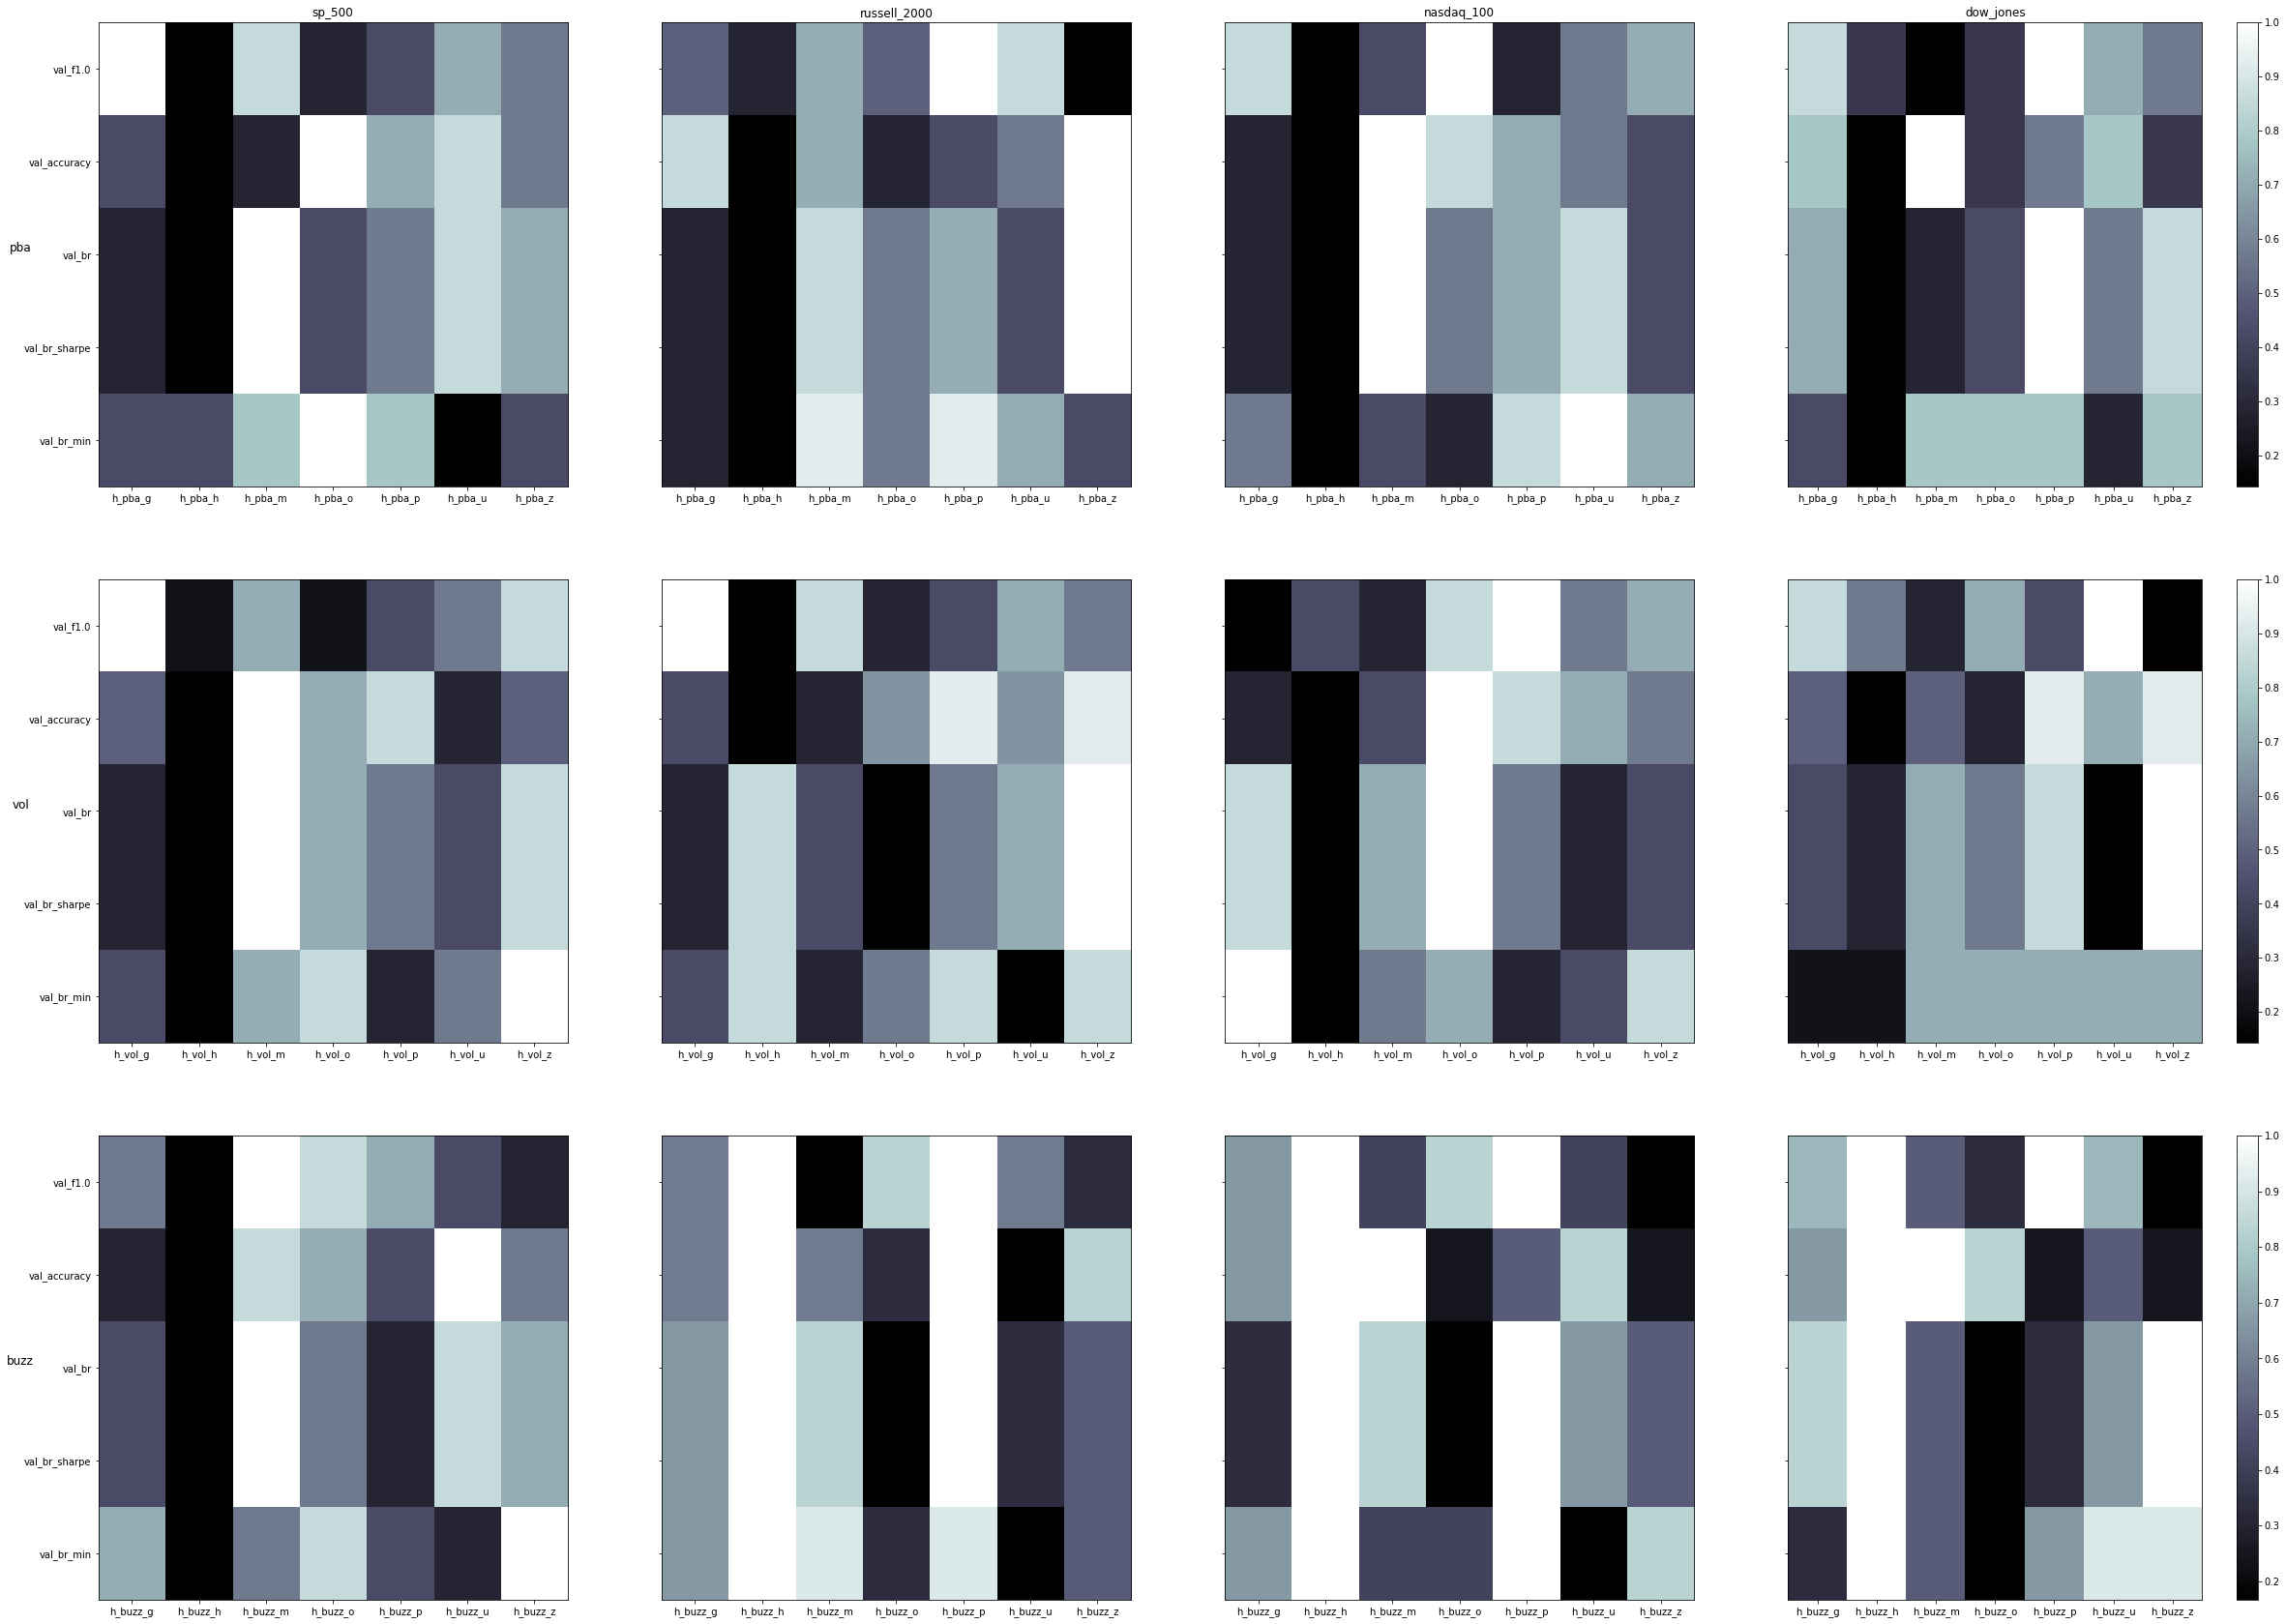

In [5]:
rank_tables = []

for src in ('pba', 'vol', 'buzz'):
    rank_tables.append([])
    for asset_name in ASSETS:
        src_study_dirs = filter(lambda p: src in basename(p), asset_study_dirs[asset_name])
        res_table = metric_rank(src_study_dirs, last_n=last_n, agg_method='max').tail(5)
        rank_table = res_table.rank(axis=1, ascending=True, pct=True)
        rank_tables[-1].append(rank_table)

f = dfs_as_heatmaps(rank_tables, row_labels=('pba', 'vol', 'buzz'), col_labels=ASSETS,
                    figsize=(40, 30), cmap='bone', aspect='auto')

### Median Value over last X%

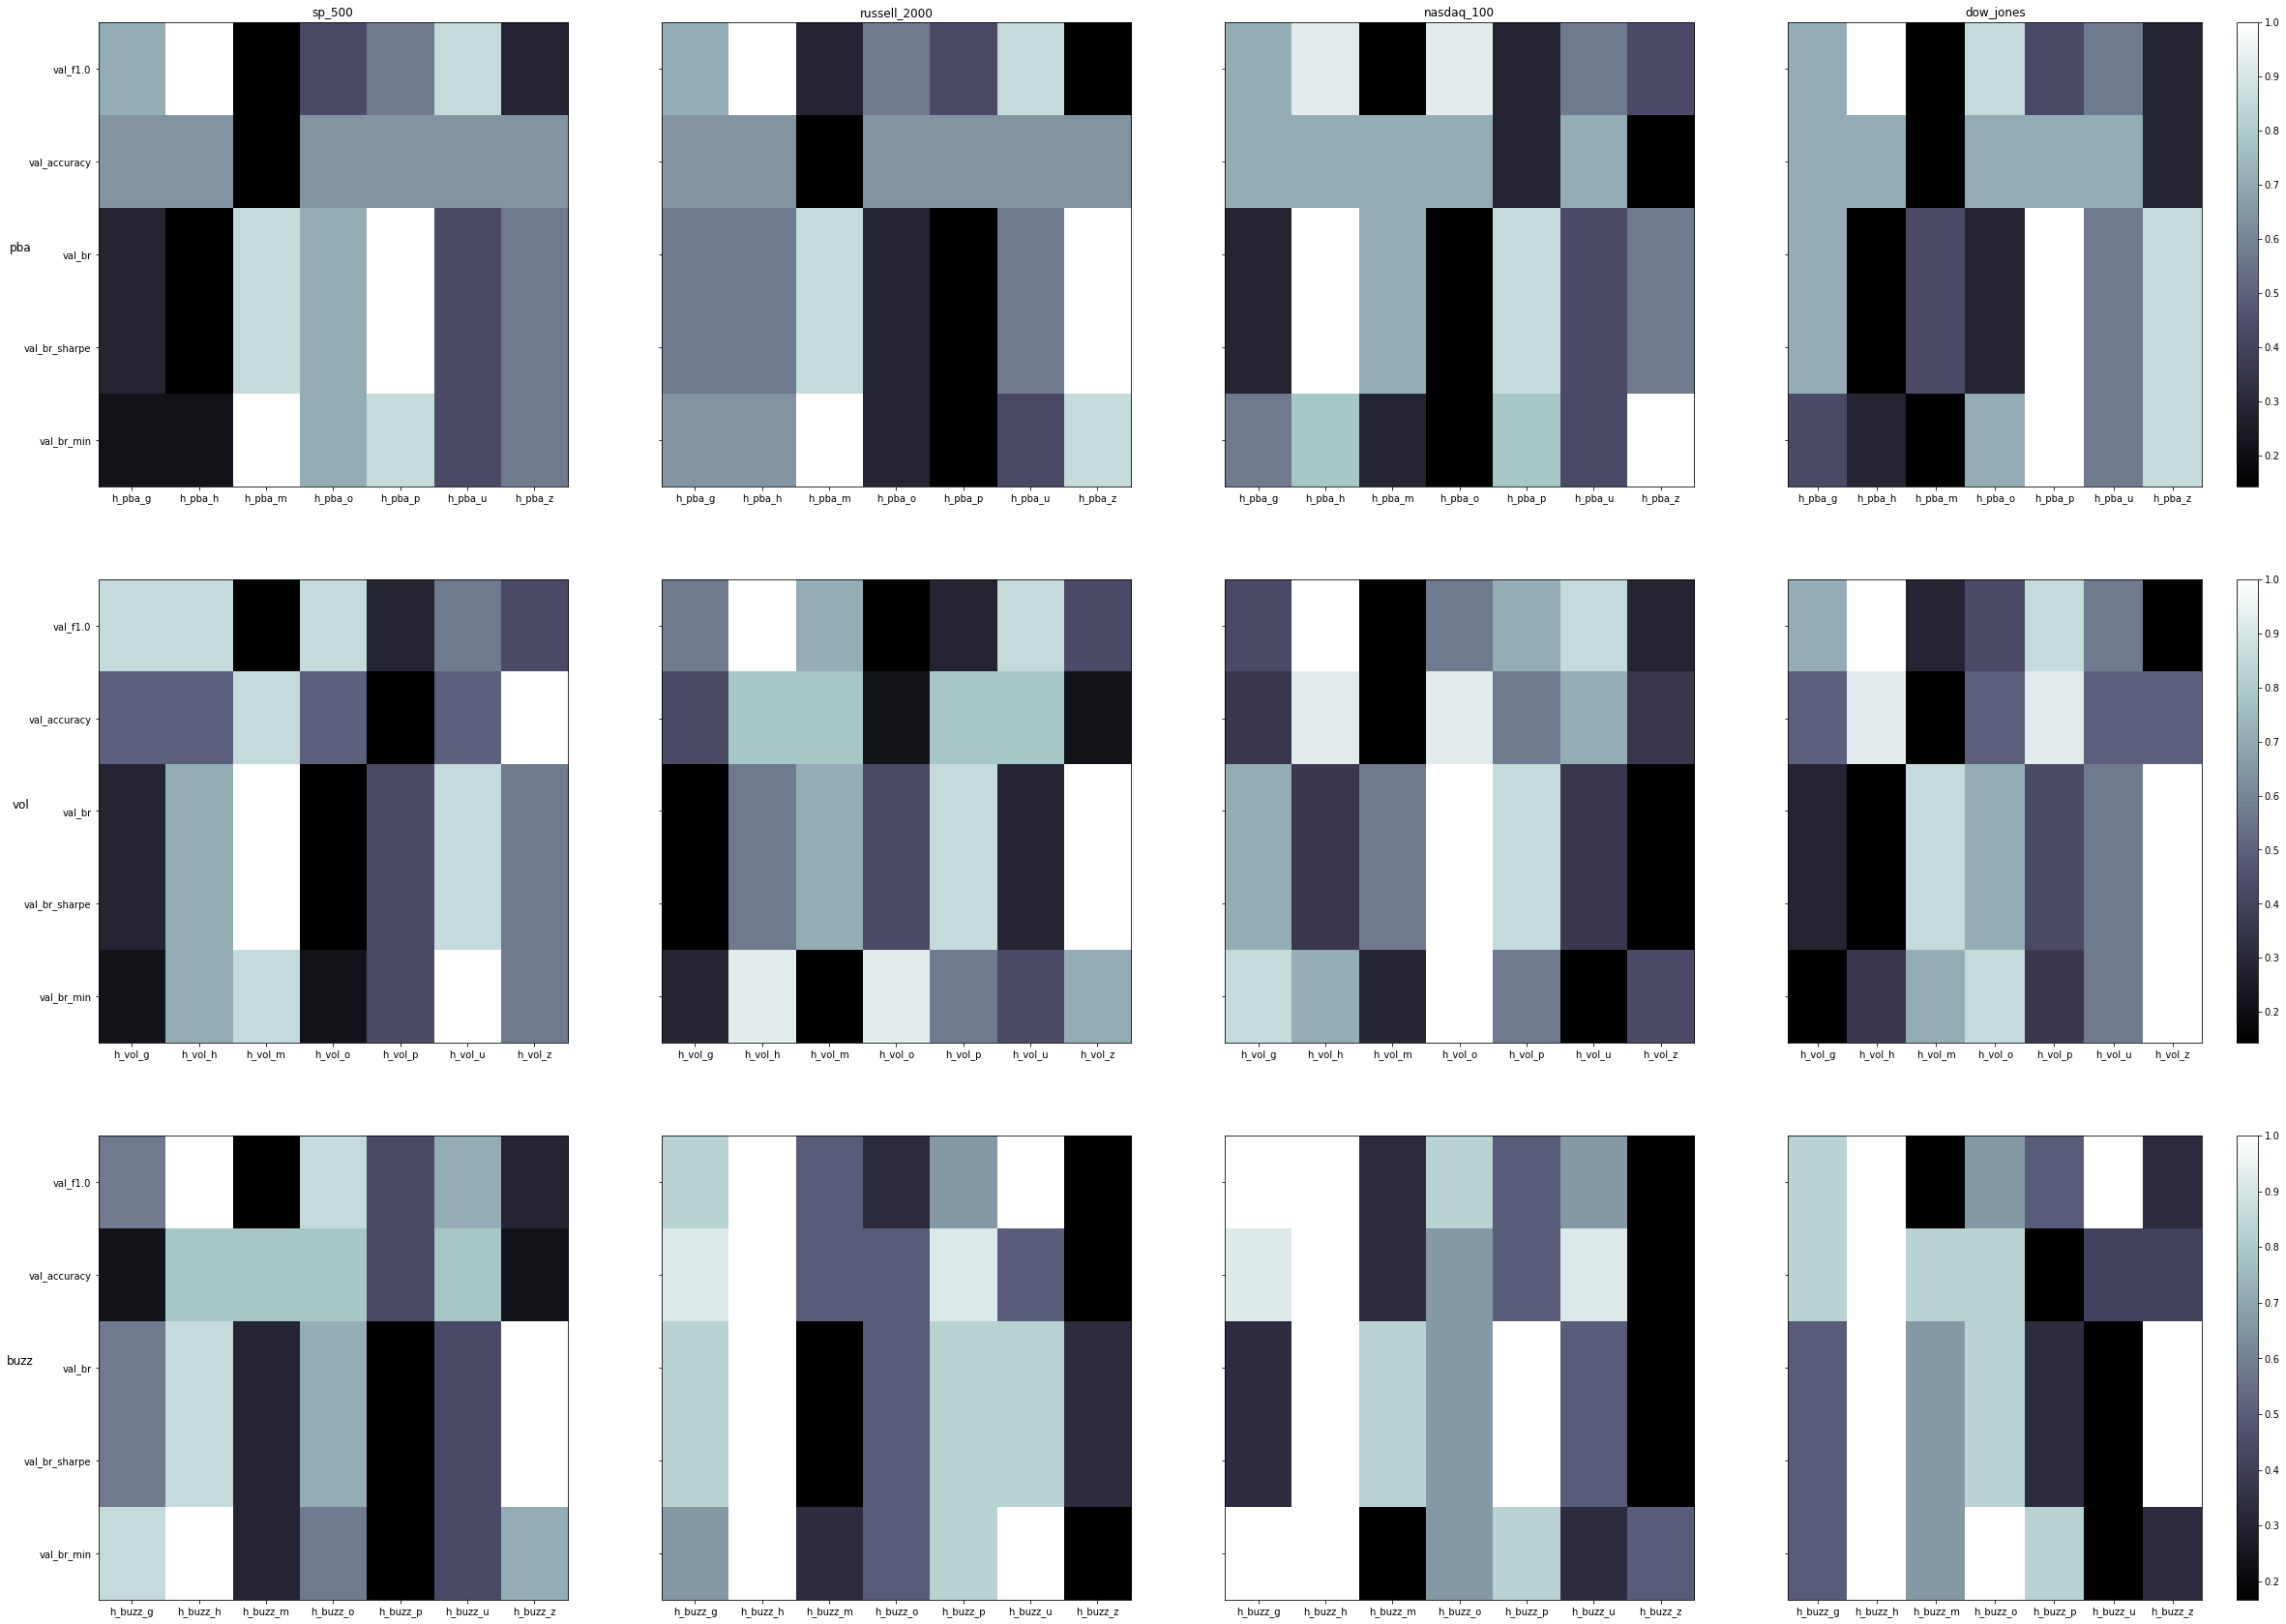

In [6]:
rank_tables = []

for src in ('pba', 'vol', 'buzz'):
    rank_tables.append([])
    for asset_name in ASSETS:
        src_study_dirs = filter(lambda p: src in basename(p), asset_study_dirs[asset_name])
        res_table = metric_rank(src_study_dirs, last_n=last_n, agg_method='median').tail(5)
        rank_table = res_table.rank(axis=1, ascending=True, pct=True)
        rank_tables[-1].append(rank_table)

f = dfs_as_heatmaps(rank_tables, row_labels=('pba', 'vol', 'buzz'), col_labels=ASSETS,
                    figsize=(40, 30), cmap='bone', aspect='auto')

## Multi

In [12]:
model_name = 'GenericModel_StackedTCN'
rank_tables = []

asset_study_dirs = {asset_name: get_asset_study_dirs(model_name, asset_name, ldata_name='ddir', filt='multi')
                    for asset_name in ASSETS}
last_n = 80

### Max Value over last X%

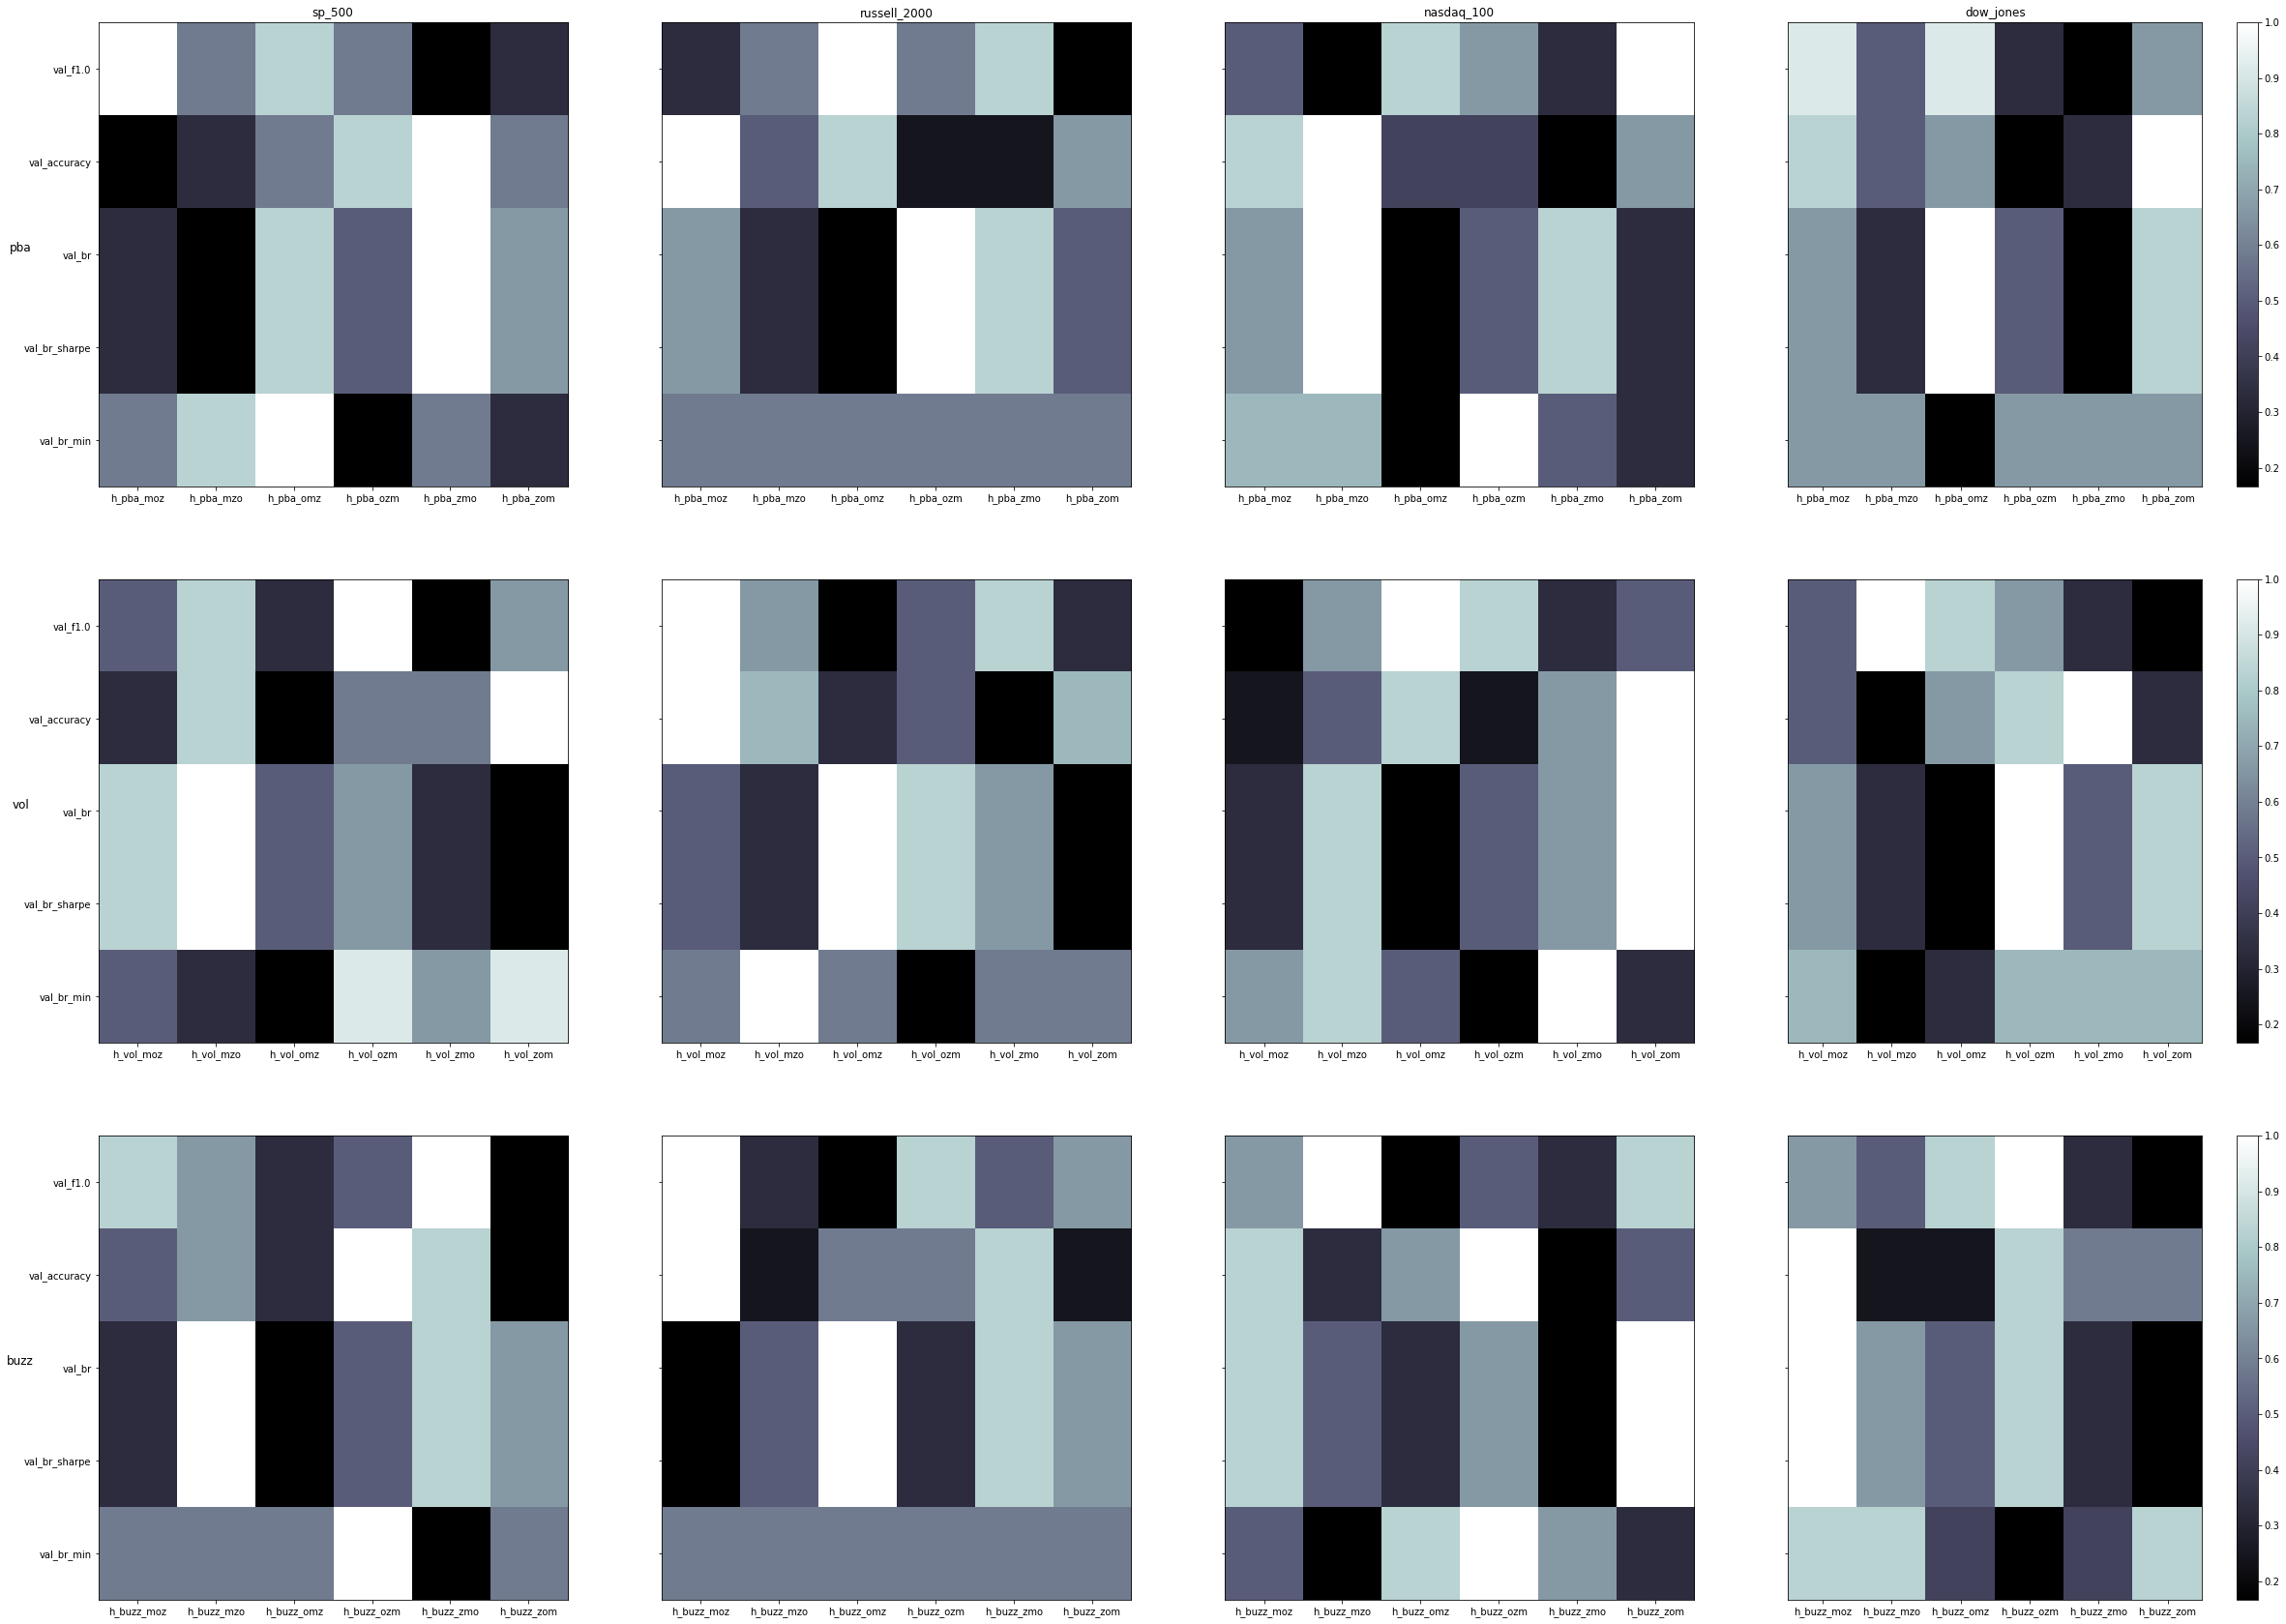

In [13]:
rank_tables = []

for src in ('pba', 'vol', 'buzz'):
    rank_tables.append([])
    for asset_name in ASSETS:
        src_study_dirs = filter(lambda p: src in basename(p), asset_study_dirs[asset_name])
        res_table = metric_rank(src_study_dirs, last_n=last_n, agg_method='max').tail(5)
        rank_table = res_table.rank(axis=1, ascending=True, pct=True)
        rank_tables[-1].append(rank_table)

f = dfs_as_heatmaps(rank_tables, row_labels=('pba', 'vol', 'buzz'), col_labels=ASSETS,
                    figsize=(40, 30), cmap='bone', aspect='auto')

### Median Value over last X%

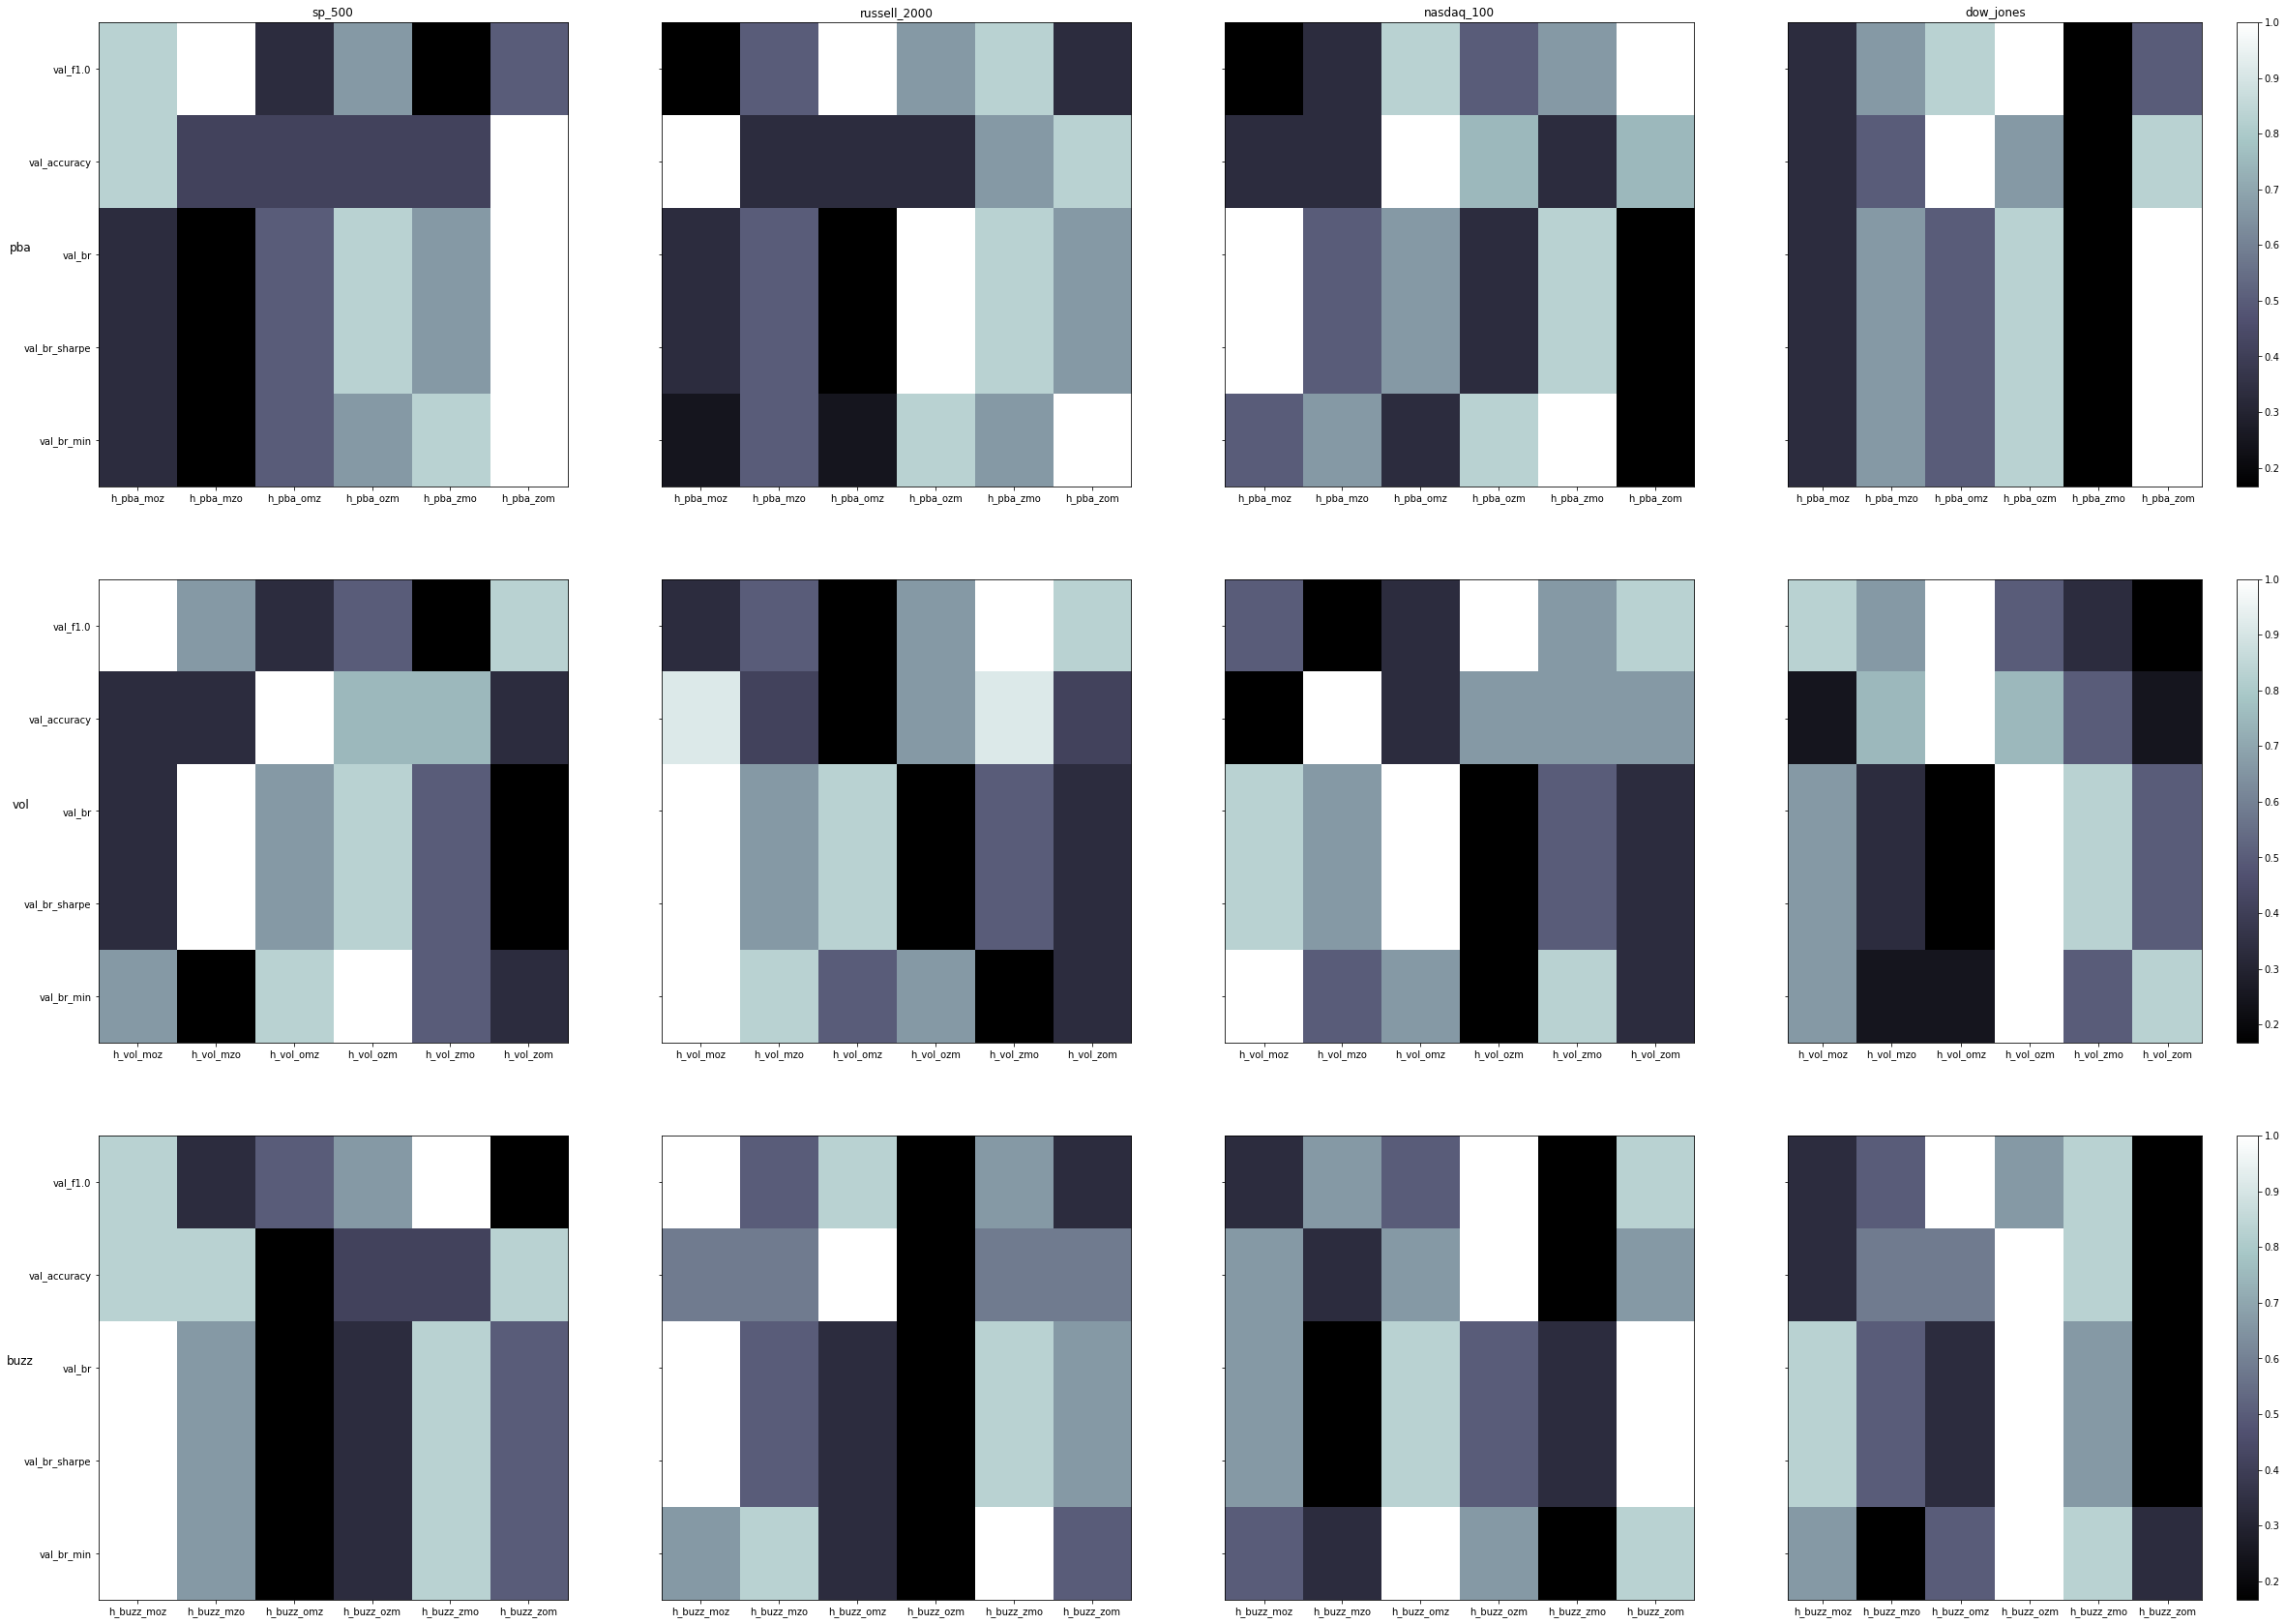

In [14]:
rank_tables = []

for src in ('pba', 'vol', 'buzz'):
    rank_tables.append([])
    for asset_name in ASSETS:
        src_study_dirs = filter(lambda p: src in basename(p), asset_study_dirs[asset_name])
        res_table = metric_rank(src_study_dirs, last_n=last_n, agg_method='median').tail(5)
        rank_table = res_table.rank(axis=1, ascending=True, pct=True)
        rank_tables[-1].append(rank_table)

f = dfs_as_heatmaps(rank_tables, row_labels=('pba', 'vol', 'buzz'), col_labels=ASSETS,
                    figsize=(40, 30), cmap='bone', aspect='auto')

In [10]:
# plot_df(r[['val_accuracy', 'val_f1.0']])
# plot_df(r[['val_br', 'val_br_sharpe', 'val_br_min']])

In [ ]:
# for asset_name in ASSETS:
#     bench = load_json('benchmark.json', list(asset_study_dirs[asset_name])[0])
#     print(f'{asset_name}')
#     print('   val ret             val sharpe')
#     print('bs', bench['val_bs'], bench['val_bs_sharpe'])
#     print('os', bench['val_os'], bench['val_os_sharpe'])
#     print(bench['val_label_dist'])
#     print()